In [1]:
import numpy as np
import scipy.linalg
import scipy.signal
import scipy.optimize
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from general_graph_utils import *

In [2]:
plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(14,12))
%config InlineBackend.figure_format = 'retina'

In [3]:
def unicycle_graph(n):
    """
    Generates a reversible unicyclic linear framework graph of size n.
    
    Parameters
    ----------
    n : integer
        the size (or number of vertices) of the graph
    
    Returns
    -------
    G : NetworkX DiGraph object
        directed graph
    
    G_ud : NetworkX Graph object
        undirected graph
    """
    
    G = nx.DiGraph()
    G_ud = nx.Graph()
    
    # determine the number of nodes in G
    G_size = n
    
    # add nodes to G and G_ud
    nodes = np.arange(1,G_size+1,step=1)
    G.add_nodes_from(nodes)
    G_ud.add_nodes_from(nodes)
    
    for i in range(2,G_size+1):
        u = i-1
        v = i
        G.add_edge(u,v)
        G.add_edge(v,u)
        G_ud.add_edge(u,v)
        
    G.add_edge(G_size,1)
    G.add_edge(1,G_size)
    G_ud.add_edge(1,G_size)
    
    return G, G_ud

In [4]:
# Function to compute the correlation function C(t)
def correlation_function_general(t, W, n):
    exp_Wt = scipy.linalg.expm(W * t) # Compute the matrix exponential e^(Wt)
    #p = np.zeros((1,n))
    #p[0] = 1
    #return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0
    return exp_Wt[0][0]

In [5]:
N = 40
G, G_ud = unicycle_graph(N)

In [6]:
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

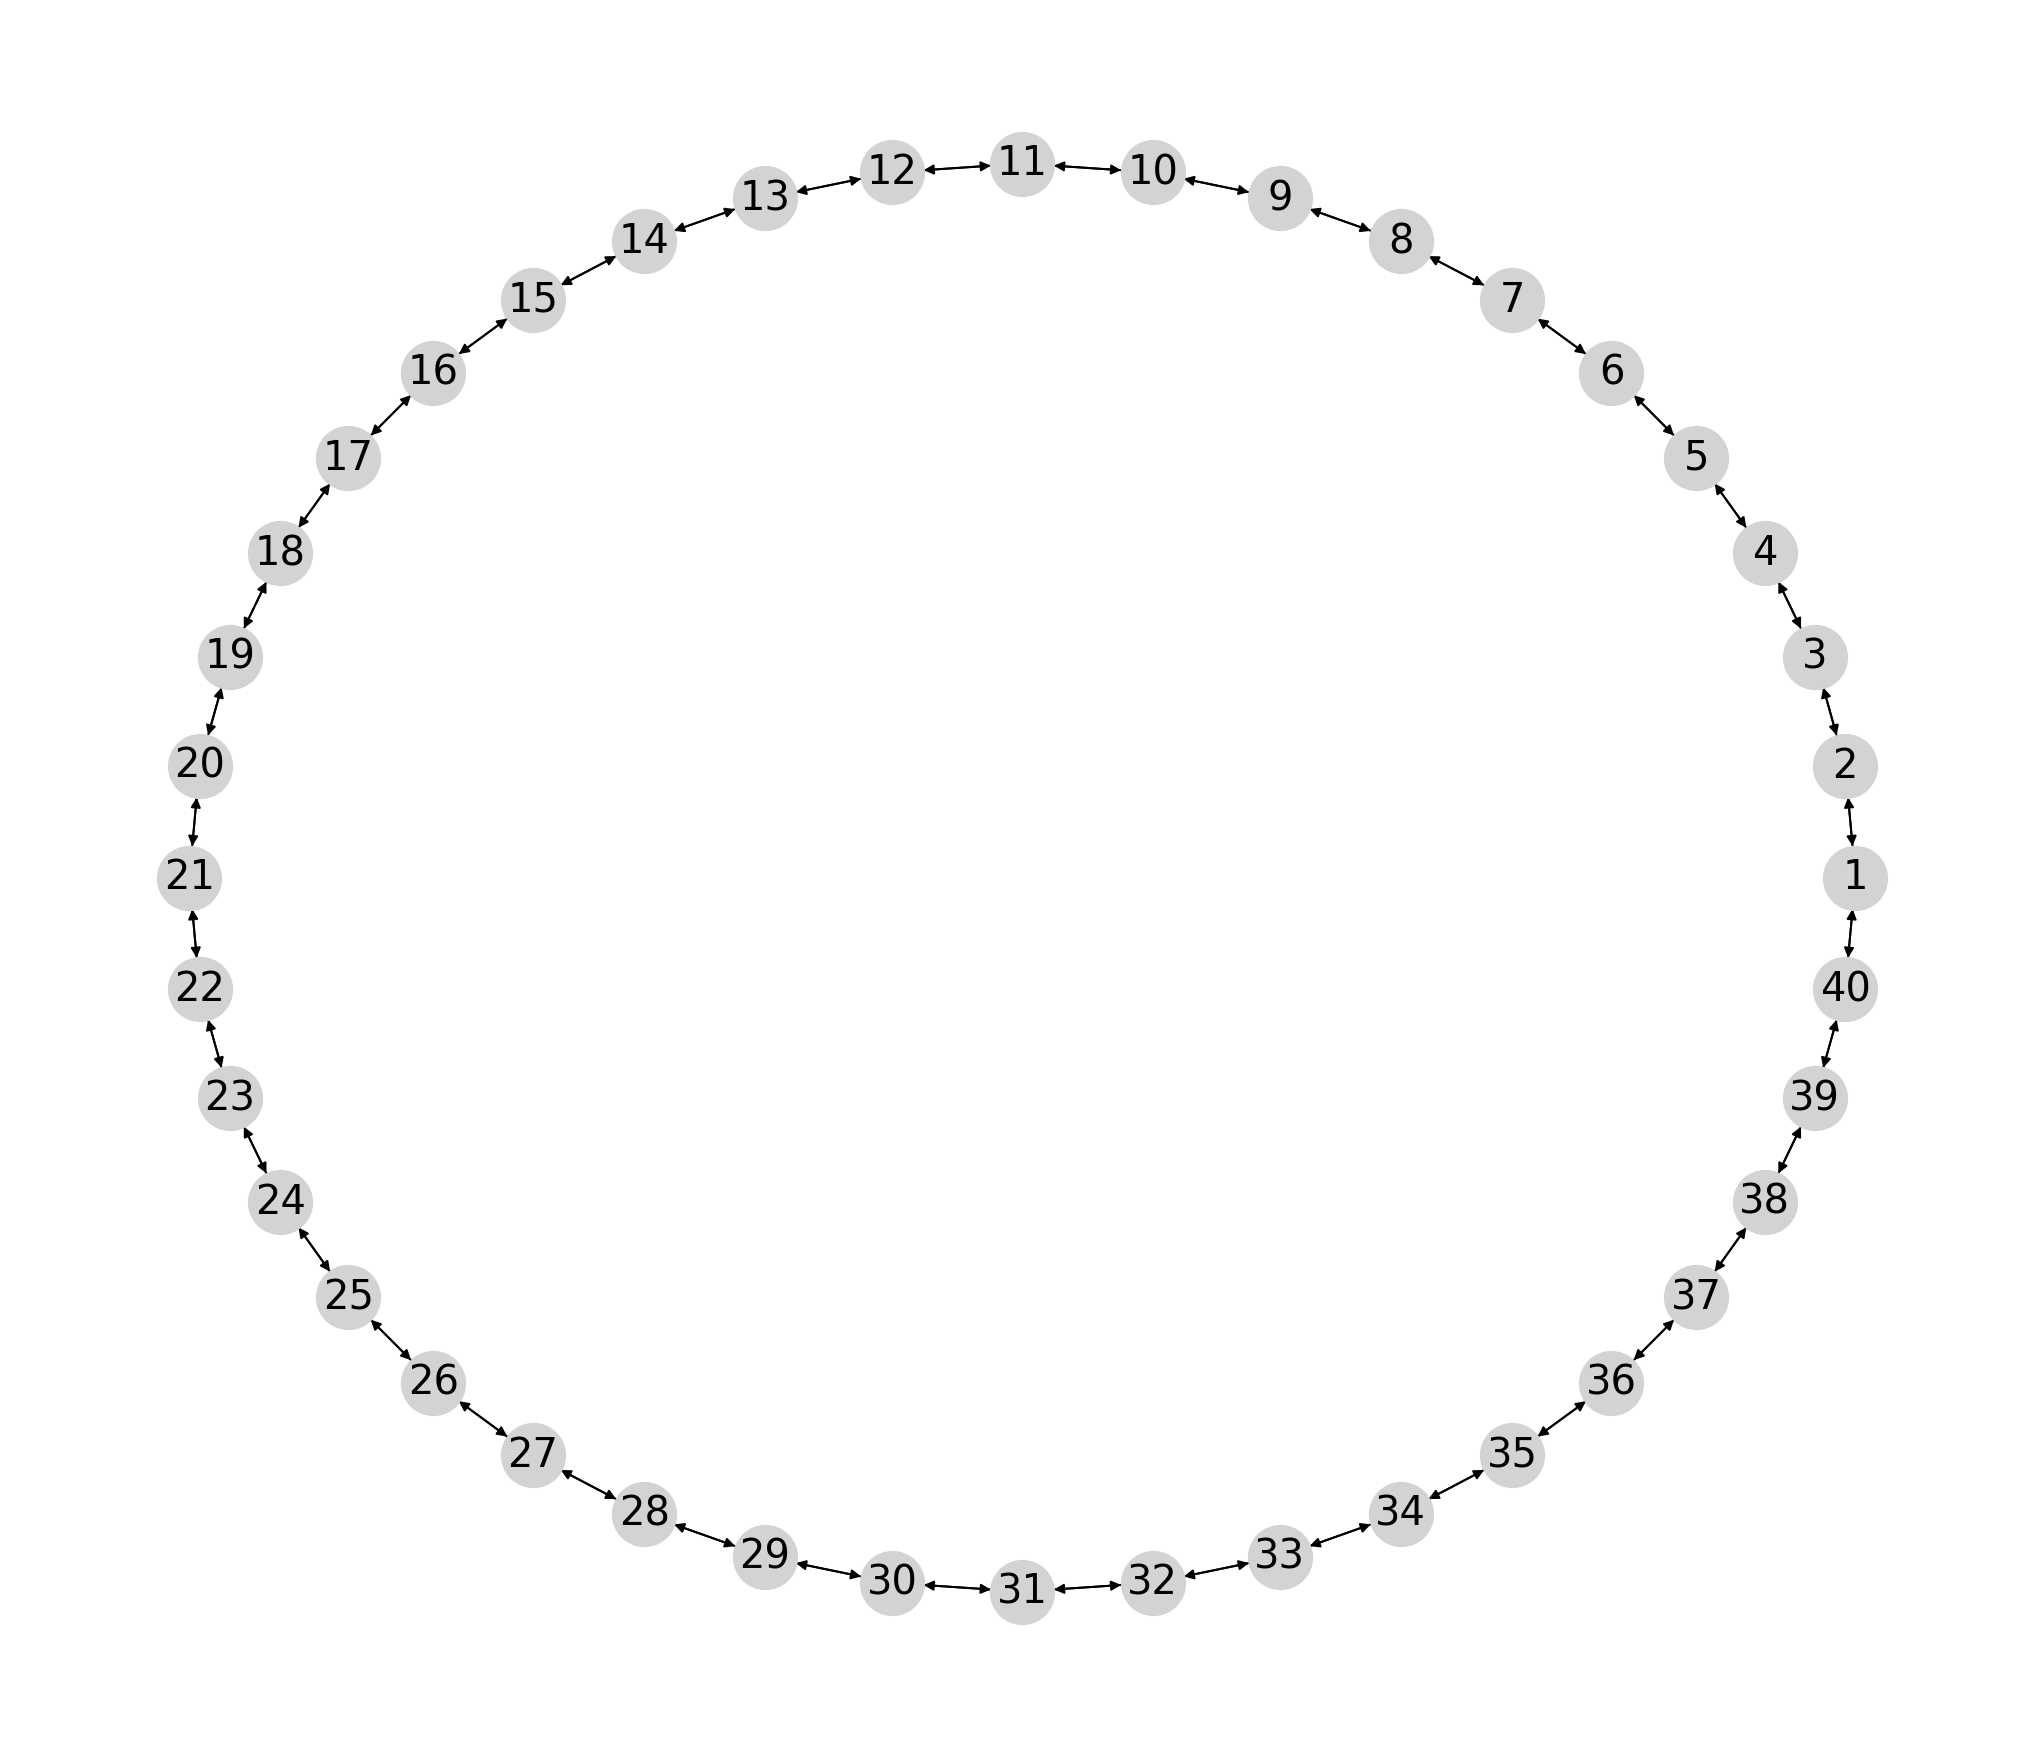

In [7]:
node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=1000, node_color = 'lightgray', font_size=20, font_color='black', font_family='sans-serif')

In [8]:
# parameter values from Barato Seifert 2017
k_m = 1.0
A = 200
k_p = k_m*np.exp(A/N)

In [9]:
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = k_p
    edge_labels_forward = np.append(edge_labels_forward, k_p)
    
    G[v][u]['weight'] = k_m
    edge_labels_backward = np.append(edge_labels_backward, k_m)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = k_p
edge_labels_forward = np.append(edge_labels_forward, k_p)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = k_m
edge_labels_backward = np.append(edge_labels_backward, k_m)

In [10]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}

In [11]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [12]:
W = Laplacian_all(edge_list,label_list,node_list)

In [13]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

200.0

In [14]:
# eigenvalues of W
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

print(x_i, x_r)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0.1, 5, 500)  # time from 0 to 1.5 with 500 pts
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=40) for t in tqdm(times)]

23.06049868410202 1.8395248228988317
decay time: 0.5436186495293611
period: 0.27246528330765174
number coherent oscillations: 19.691686774828682


100%|█████████████████████████████████████████| 500/500 [01:01<00:00,  8.13it/s]


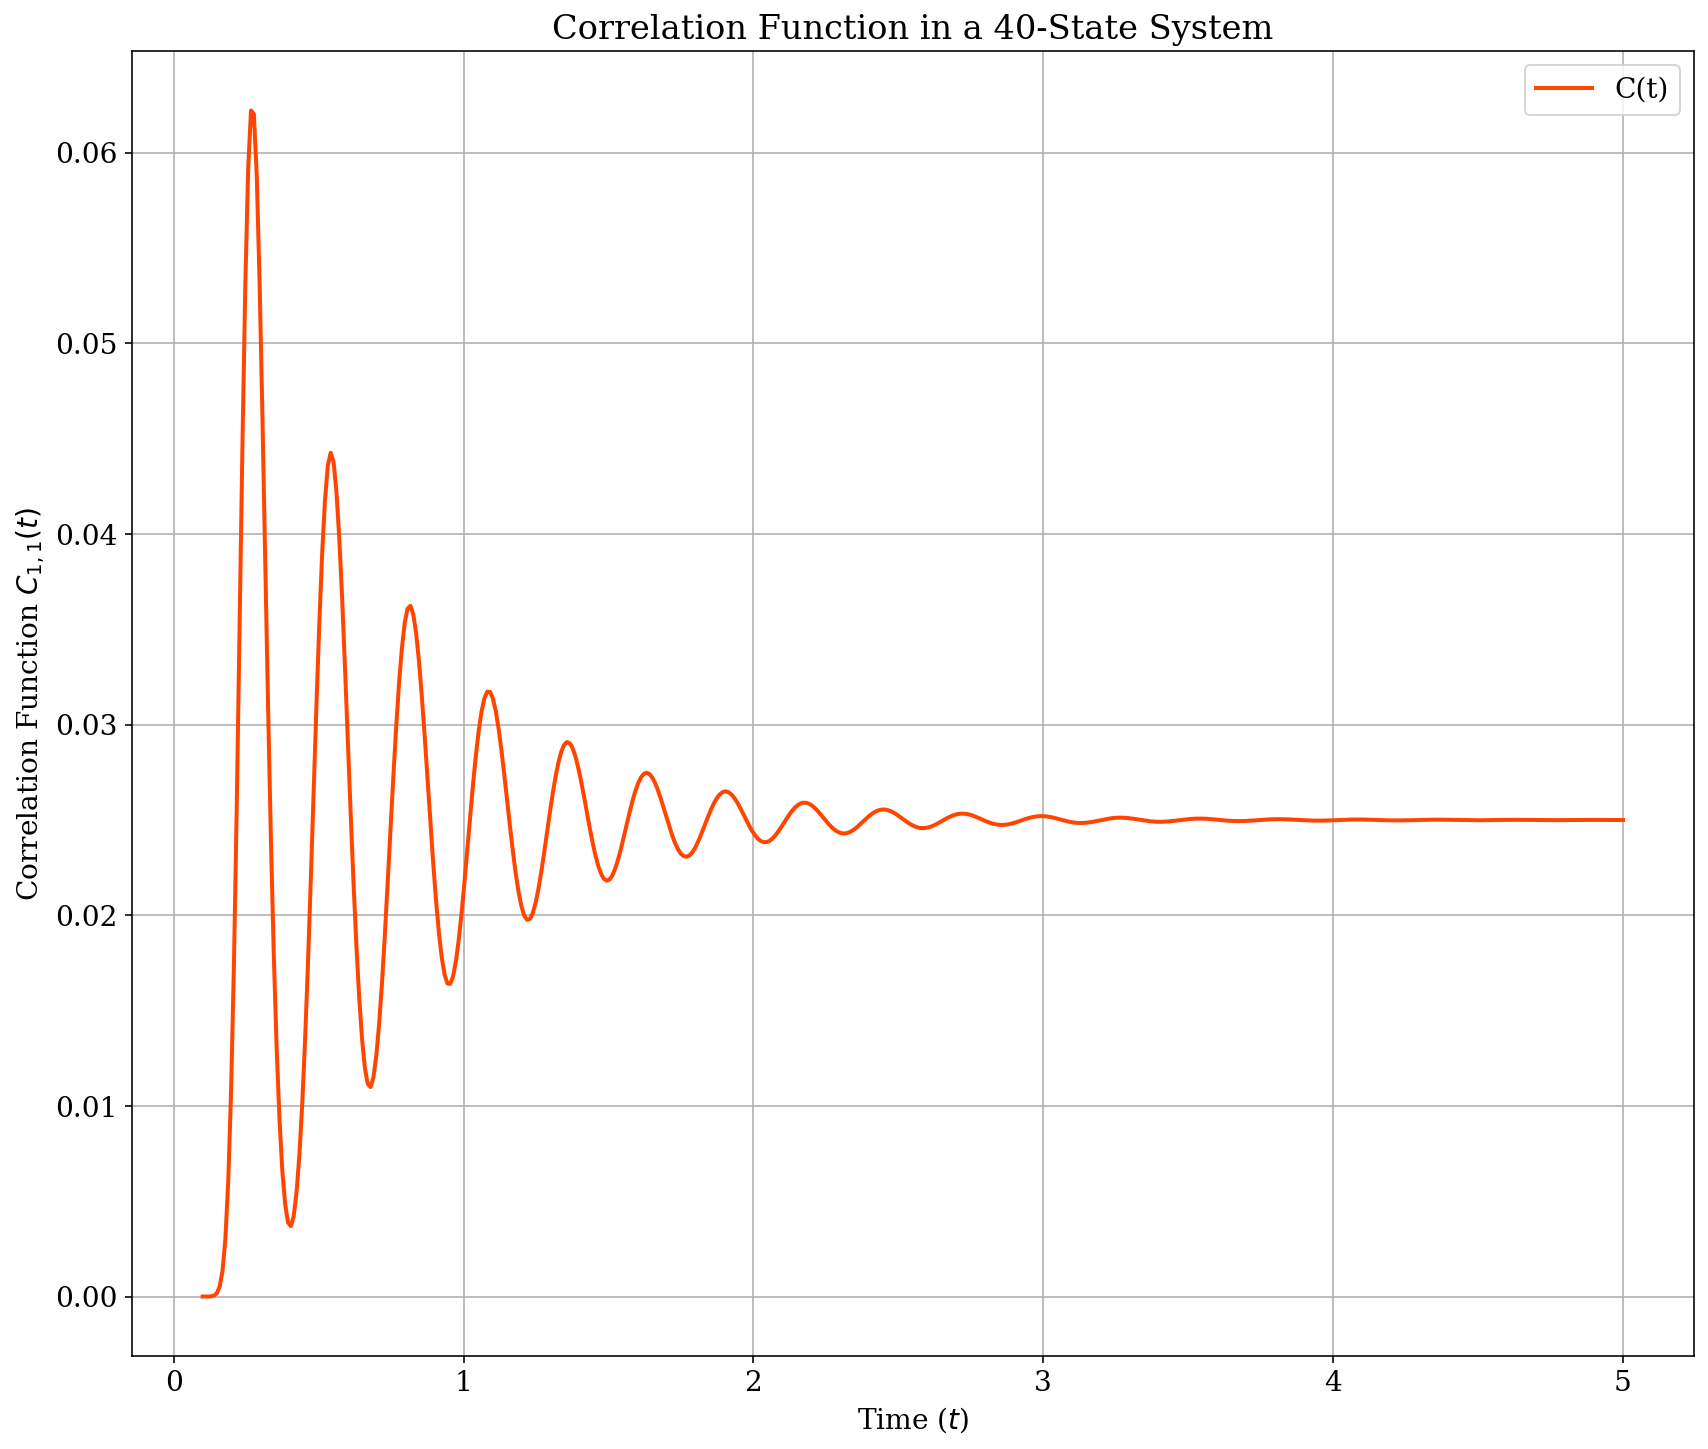

In [15]:
num_states = str(N)
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a '+ num_states +'-State System')
plt.legend()
plt.grid()
plt.show()